In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from models.Loader import load_model
from models.Wrappers import Transformer_wrapper, Reduced_transformer_wrapper, Reduced_io_transformer_wrapper, Reduced_o_DLinear_wrapper, Reduced_o_NLinear_wrapper
from torch.autograd import Variable
from utils.shap_tools import ChronoSHAP
from cycler import cycler

# import argparse
import os
import torch
# import copy
# from exp.exp_main import Exp_Main
# import random
import numpy as np

import shap
import pickle

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


%matplotlib qt5 
# %matplotlib widget
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"

In [27]:
import pandas as pd 

data_path = "dataset/"
datasets = dict()

# data_files = os.listdir(data_path)
# data_files.remove("all_six_datasets.zip")
# print(len(data_files))

dataset_key = "national_illness"
# for f in ["electricity.csv", "ETTh1.csv", "ETTh2.csv", "ETTm1.csv", "ETTm2.csv", "exchange_rate.csv", "national_illness.csv", "traffic.csv", "weather.csv"]:
for f in ["{}.csv".format(dataset_key)]:
    print(f.replace(".csv",""))        
    dataset = pd.read_csv(data_path+f)
#     display(dataset.describe())
    datasets[f.replace(".csv","")] = dataset

national_illness


In [3]:
for dataset in datasets:
    print(dataset, datasets[dataset].shape)

electricity (26304, 322)
ETTh1 (17420, 8)
ETTh2 (17420, 8)
ETTm1 (69680, 8)
ETTm2 (69680, 8)
exchange_rate (7588, 9)
national_illness (966, 8)
traffic (17544, 863)
weather (52696, 22)


date                  object
% WEIGHTED ILI       float64
%UNWEIGHTED ILI      float64
AGE 0-4                int64
AGE 5-24               int64
ILITOTAL               int64
NUM. OF PROVIDERS      int64
OT                     int64
dtype: object


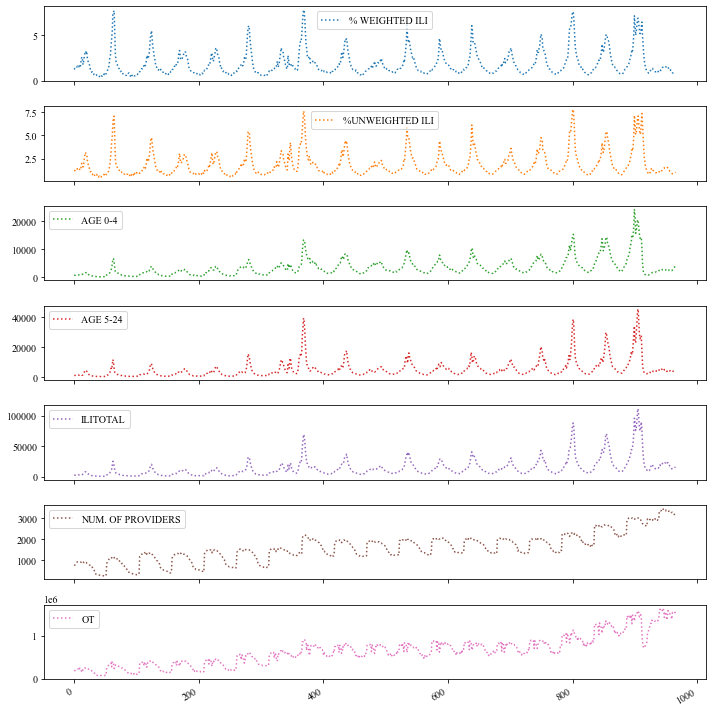

In [28]:
dset = datasets[dataset_key]
print(dset.dtypes)

# %matplotlib inline 
datasets[dataset_key].plot(subplots=True, figsize=(10, 10))
plt.tight_layout()
plt.show()

# dset = datasets["exchange_rate"].loc[:, datasets["exchange_rate"].columns != 'date']

Arg use_gpu initial: True
Args in experiment:
Namespace(activation='gelu', batch_size=8, c_out=7, checkpoints='\\checkpoints', d_ff=2048, d_layers=1, d_model=512, data='custom', data_path='national_illness.csv', dec_in=7, des='Exp', devices='0,1,2,3', distil=True, do_predict=False, dropout=0.05, e_layers=2, embed='timeF', embed_type=0, enc_in=7, factor=1, features='M', freq='h', gpu=0, individual=True, is_training=1, itr=1, label_len=18, learning_rate=0.0005, loss='mse', lradj='type1', model='NLinear', model_id='national_illness_36_36', moving_avg=25, n_heads=8, num_workers=0, output_attention=False, patience=5, pred_len=36, root_path='./dataset/', save_pred_values=False, seed=28649, seq_len=36, target='OT', test_flop=False, train_epochs=20, train_only=False, use_amp=False, use_gpu=True, use_multi_gpu=False)
Use GPU: cuda:0
checkpoints/national_illness_36_36_NLinear_custom_ftM_sl36_ll18_pl36_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0_seed28649/checkpoint.pth
test 158
mse:2.44675

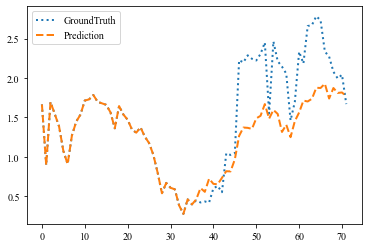

In [29]:
model_args = {}

exch_model_args = [
    "--is_training", "1", \
    "--seed", "15349", \
    "--num_workers", "0", \
    "--root_path", "./dataset/", \
    "--data_path", "{}.csv".format("exchange_rate"), \
    "--model_id", "{}_96_96".format("exchange"), \
    "--model", "NLinear", \
    "--data", "custom", \
    "--features", "M", \
    "--seq_len", "96", \
    "--pred_len", "96", \
    "--enc_in", "8", \
    "--c_out", "8", \
    "--des", 'Exp', \
    "--itr", "1", \
    "--train_epochs", "20", \
    "--patience", "5", \
    "--batch_size", "8", \
    "--learning_rate", "0.0005", \
    "--individual", \
    "--use_gpu", False, \
    "--checkpoints", "\checkpoints"]
model_args["exchange_rate"] = exch_model_args

etth1_model_args = [
    "--is_training", "1", \
    "--seed", "15726", \
    "--num_workers", "0", \
    "--root_path", "./dataset/", \
    "--data_path", "{}.csv".format("ETTh1"), \
    "--model_id", "{}_96_96".format("ETTh1"), \
    "--model", "NLinear", \
    "--data", "{}".format("ETTh1"), \
    "--features", "M", \
    "--seq_len", "96", \
    "--pred_len", "96", \
    "--enc_in", "7", \
    "--c_out", "7", \
    "--des", 'Exp', \
    "--itr", "1", \
    "--train_epochs", "20", \
    "--patience", "5", \
    "--batch_size", "8", \
    "--learning_rate", "0.0005", \
    "--individual", \
    "--use_gpu", False, \
    "--checkpoints", "\checkpoints"]
model_args["ETTh1"] = etth1_model_args

etth2_model_args = [
    "--is_training", "1", \
    "--seed", "15349", \
    "--num_workers", "0", \
    "--root_path", "./dataset/", \
    "--data_path", "{}.csv".format("ETTh2"), \
    "--model_id", "{}_96_96".format("ETTh2"), \
    "--model", "NLinear", \
    "--data", "{}".format("ETTh2"), \
    "--features", "M", \
    "--seq_len", "96", \
    "--pred_len", "96", \
    "--enc_in", "7", \
    "--c_out", "7", \
    "--des", 'Exp', \
    "--itr", "1", \
    "--train_epochs", "20", \
    "--patience", "5", \
    "--batch_size", "8", \
    "--learning_rate", "0.0005", \
    "--individual", \
    "--use_gpu", False, \
    "--checkpoints", "\checkpoints"]
model_args["ETTh2"] = etth2_model_args

ettm1_model_args = [
    "--is_training", "1", \
    "--seed", "15349", \
    "--num_workers", "0", \
    "--root_path", "./dataset/", \
    "--data_path", "{}.csv".format("ETTm1"), \
    "--model_id", "{}_96_96".format("ETTm1"), \
    "--model", "NLinear", \
    "--data", "{}".format("ETTm1"), \
    "--features", "M", \
    "--seq_len", "96", \
    "--pred_len", "96", \
    "--enc_in", "7", \
    "--c_out", "7", \
    "--des", 'Exp', \
    "--itr", "1", \
    "--train_epochs", "20", \
    "--patience", "5", \
    "--batch_size", "8", \
    "--learning_rate", "0.0005", \
    "--individual", \
    "--use_gpu", False, \
    "--checkpoints", "\checkpoints"]
model_args["ETTm1"] = ettm1_model_args

ettm2_model_args = [
    "--is_training", "1", \
    "--seed", "15227", \
    "--num_workers", "0", \
    "--root_path", "./dataset/", \
    "--data_path", "{}.csv".format("ETTm2"), \
    "--model_id", "{}_96_96".format("ETTm2"), \
    "--model", "NLinear", \
    "--data", "{}".format("ETTm2"), \
    "--features", "M", \
    "--seq_len", "96", \
    "--pred_len", "96", \
    "--enc_in", "7", \
    "--c_out", "7", \
    "--des", 'Exp', \
    "--itr", "1", \
    "--train_epochs", "20", \
    "--patience", "5", \
    "--batch_size", "8", \
    "--learning_rate", "0.0005", \
    "--individual", \
    "--use_gpu", False, \
    "--checkpoints", "\checkpoints"]
model_args["ETTm2"] = ettm2_model_args


weather_model_args = [
    "--is_training", "1", \
    "--seed", "15349", \
    "--num_workers", "0", \
    "--root_path", "./dataset/", \
    "--data_path", "{}.csv".format("weather"), \
    "--model_id", "{}_96_96".format("weather"), \
    "--model", "NLinear", \
    "--data", "custom", \
    "--features", "M", \
    "--seq_len", "96", \
    "--pred_len", "96", \
    "--enc_in", "21", \
    "--c_out", "21", \
    "--des", 'Exp', \
    "--itr", "1", \
    "--train_epochs", "20", \
    "--patience", "5", \
    "--batch_size", "16", \
    "--learning_rate", "0.005", \
    "--individual", \
#     "--use_gpu", False, \
    "--checkpoints", "\checkpoints"]
model_args["weather"] = weather_model_args


ili_model_args = [
    "--is_training", "1", \
    "--seed", "28649", \
    "--num_workers", "0", \
    "--root_path", "./dataset/", \
    "--data_path", "{}.csv".format("national_illness"), \
    "--model_id", "{}_36_36".format("national_illness"), \
    "--model", "NLinear", \
    "--data", "custom", \
    "--features", "M", \
    "--seq_len", "36", \
    "--label_len", "18", \
    "--pred_len", "36", \
    "--enc_in", "7", \
    "--c_out", "7", \
    "--des", 'Exp', \
    "--itr", "1", \
    "--train_epochs", "20", \
    "--patience", "5", \
    "--batch_size", "8", \
    "--learning_rate", "0.0005", \
    "--individual", \
#     "--use_gpu", False, \
    "--checkpoints", "\checkpoints"]
model_args["national_illness"] = ili_model_args

# ETTh1
# ETTh2
# ETTm1
# ETTm2
# exchange_rate
# national_illness
# weather
dataset_key = "national_illness"

# for dataset_key in ["exchange_rate", "ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "national_illness.csv"]:
#     exp, model, setting = load_model(model_args[dataset_key], load=True, return_copy=False)
#     model.eval()
#     exp.test(setting)


exp, model, setting = load_model(model_args[dataset_key], load=True, return_copy=False)
# exp_no_train, model_no_train, setting_no_train = load_model(model_args, load=False, return_copy=False)

model.eval()
# model_no_train.eval()

# print("Testing trained model")
exp.test(setting)
# print("Testing untrained model")
# exp_no_train.test(setting_no_train)

# display(model)

In [30]:
model

Model(
  (Linear): ModuleList(
    (0): Linear(in_features=36, out_features=36, bias=True)
    (1): Linear(in_features=36, out_features=36, bias=True)
    (2): Linear(in_features=36, out_features=36, bias=True)
    (3): Linear(in_features=36, out_features=36, bias=True)
    (4): Linear(in_features=36, out_features=36, bias=True)
    (5): Linear(in_features=36, out_features=36, bias=True)
    (6): Linear(in_features=36, out_features=36, bias=True)
  )
)

# Prepare inputs of the model

In [31]:
train_data, train_loader = exp._get_data("train")
for i, (batch_x_train_b, batch_y_train_b, batch_x_mark_train_b, batch_y_mark_train_b) in enumerate(train_loader):
#     print("i={}, Shapes of batch_x: {}, batch_x_mark: {}, batch_y: {}, batch_y_mark: {}".format(i, batch_x_train_b.shape, batch_x_mark_train_b.shape, batch_y_train_b.shape, batch_y_mark_train_b.shape))
    if (i==0):
        batch_x_train = torch.cat((batch_x_train_b,))
        batch_y_train = torch.cat((batch_y_train_b,))
        batch_x_mark_train = torch.cat((batch_x_mark_train_b,))
        batch_y_mark_train = torch.cat((batch_y_mark_train_b,))
    else:
        batch_x_train = torch.cat((batch_x_train, batch_x_train_b))
        batch_y_train = torch.cat((batch_y_train, batch_y_train_b))
        batch_x_mark_train = torch.cat((batch_x_mark_train, batch_x_mark_train_b))
        batch_y_mark_train = torch.cat((batch_y_mark_train, batch_y_mark_train_b))

batch_x_train = batch_x_train.float().to(next(model.parameters()).device)
batch_y_train = batch_y_train.float().to(next(model.parameters()).device)
batch_x_mark_train = batch_x_mark_train.float().to(next(model.parameters()).device)
batch_y_mark_train = batch_y_mark_train.float().to(next(model.parameters()).device)

# dec_inp_train = torch.zeros_like(batch_y_train[:, -train_data.pred_len:, :]).float()
# dec_inp_train = torch.cat([batch_y_train[:, :train_data.label_len, :], dec_inp_train], dim=1).float().to(next(model.parameters()).device)

dec_inp_train = torch.zeros([batch_y_train.shape[0], train_data.pred_len, batch_y_train.shape[2]]).float().to(batch_y_train.device)
dec_inp_train = torch.cat([batch_y_train[:, :train_data.label_len, :], dec_inp_train], dim=1).float().to(next(model.parameters()).device)

print("Model input shapes: batch_x: {}, batch_x_mark: {}, dec_inp: {}, batch_y_mark: {}".format(batch_x_train.shape, batch_x_mark_train.shape, dec_inp_train.shape, batch_y_mark_train.shape))

train 605
Model input shapes: batch_x: torch.Size([600, 36, 7]), batch_x_mark: torch.Size([600, 36, 4]), dec_inp: torch.Size([600, 54, 7]), batch_y_mark: torch.Size([600, 54, 4])


In [32]:
pred_data, pred_loader = exp._get_data("pred")

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
    print("Shapes of batch_x: {}, batch_x_mark: {}, batch_y: {}, batch_y_mark: {}".format(batch_x.shape, batch_x_mark.shape, batch_y.shape, batch_y_mark.shape))
#     print("batch_x: ",batch_x[0,:,0])
#     print("batch_y: ",batch_y[0,:,0])
    print()

batch_x = batch_x.float().to(next(model.parameters()).device)
batch_y = batch_y.float().to(next(model.parameters()).device)
batch_x_mark = batch_x_mark.float().to(next(model.parameters()).device)
batch_y_mark = batch_y_mark.float().to(next(model.parameters()).device)

dec_inp = torch.zeros([batch_y.shape[0], pred_data.pred_len, batch_y.shape[2]]).float().to(batch_y.device)
dec_inp = torch.cat([batch_y[:, :pred_data.label_len, :], dec_inp], dim=1).float().to(next(model.parameters()).device)

print("Model input shapes: batch_x: {}, batch_x_mark: {}, dec_inp: {}, batch_y_mark: {}".format(batch_x.shape, batch_x_mark.shape, dec_inp.shape, batch_y_mark.shape))

pred 1
Shapes of batch_x: torch.Size([1, 36, 7]), batch_x_mark: torch.Size([1, 36, 4]), batch_y: torch.Size([1, 18, 7]), batch_y_mark: torch.Size([1, 54, 4])

Model input shapes: batch_x: torch.Size([1, 36, 7]), batch_x_mark: torch.Size([1, 36, 4]), dec_inp: torch.Size([1, 54, 7]), batch_y_mark: torch.Size([1, 54, 4])


### The DLinear model is purely autoregressive, as it does not contemplates spacial correlations

In [33]:
aux_batch_x = batch_x.clone().detach()

aux_batch_x[:,:,::2] = 0

(model(batch_x)[:,:,:]-model(aux_batch_x)[:,:,:]).sum(dim=0)

tensor([[-0.6662,  0.0000,  0.1916,  0.0000,  0.1504,  0.0000,  2.5070],
        [-0.6092,  0.0000,  0.1816,  0.0000,  0.1136,  0.0000,  2.4721],
        [-0.6216,  0.0000,  0.1125,  0.0000,  0.1187,  0.0000,  2.3626],
        [-0.6343,  0.0000,  0.0658,  0.0000,  0.0534,  0.0000,  2.5036],
        [-0.6091,  0.0000,  0.0403,  0.0000,  0.1634,  0.0000,  2.4434],
        [-0.6224,  0.0000,  0.0107,  0.0000,  0.1080,  0.0000,  2.2602],
        [-0.6069,  0.0000, -0.0557,  0.0000,  0.1085,  0.0000,  2.2245],
        [-0.6164,  0.0000, -0.0915,  0.0000,  0.0211,  0.0000,  2.0698],
        [-0.6213,  0.0000, -0.0994,  0.0000,  0.0530,  0.0000,  2.1135],
        [-0.6299,  0.0000, -0.1647,  0.0000,  0.0802,  0.0000,  2.1445],
        [-0.6105,  0.0000, -0.1661,  0.0000,  0.0317,  0.0000,  2.2318],
        [-0.5962,  0.0000, -0.2199,  0.0000,  0.0754,  0.0000,  2.2733],
        [-0.6430,  0.0000, -0.2583,  0.0000,  0.0804,  0.0000,  2.0836],
        [-0.6014,  0.0000, -0.2920,  0.0000,  0.102

# Reduced inputs and outputs model

In [34]:
reduced_o_wrapped_model = Reduced_o_NLinear_wrapper(exp.args).float().to(exp.device)
reduced_o_wrapped_model.load_state_dict(model.state_dict())
reduced_o_wrapped_model.eval()

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
exp.device = device
reduced_o_wrapped_model.to(device)

Reduced_o_NLinear_wrapper(
  (Linear): ModuleList(
    (0): Linear(in_features=36, out_features=36, bias=True)
    (1): Linear(in_features=36, out_features=36, bias=True)
    (2): Linear(in_features=36, out_features=36, bias=True)
    (3): Linear(in_features=36, out_features=36, bias=True)
    (4): Linear(in_features=36, out_features=36, bias=True)
    (5): Linear(in_features=36, out_features=36, bias=True)
    (6): Linear(in_features=36, out_features=36, bias=True)
  )
)

In [35]:
# Create list to identify feature and position in the input sequence
feature_list = []
for i in range(exp.args.c_out*exp.args.seq_len):
    feature_list.append("Feature {}, seq pos {} ".format(pred_data.cols[1:][i%exp.args.c_out], int(i/exp.args.c_out)))

In [36]:
print(exp.args.c_out)
print(exp.args.seq_len)
print(len(feature_list))

7
36
252


## DeepSHAP explainer (based on DeepLift)

In [13]:
num_train_samples = 128

# Get a subset of the train data
batch_x_train_sub = batch_x_train[:num_train_samples,:,:]

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
exp.device = device
reduced_o_wrapped_model.to(device)

# Flatten X to be fed to the model

reduced_new_input = batch_x.flatten(start_dim=1).to(device)
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1).to(device)

reduced_o_wrapped_model.set_pred_time_step(0)

torch.set_grad_enabled(True)

e = shap.DeepExplainer(reduced_o_wrapped_model, reduced_new_input_train)
reduced_o_deep_shap_values = e.shap_values(reduced_new_input)

In [14]:
with open('Explanations/SHAP/dlinear_reduced_o_deep_shap_values_data_{}_backgr_{}.pkl'.format(dataset_key, num_train_samples), 'wb') as file:
    pickle.dump(reduced_o_deep_shap_values, file)

with open('Explanations/SHAP/dlinear_reduced_o_deep_shap_values_data_{}_backgr_{}.pkl'.format(dataset_key, num_train_samples), 'rb') as file:
    reduced_o_deep_shap_values = pickle.load(file)

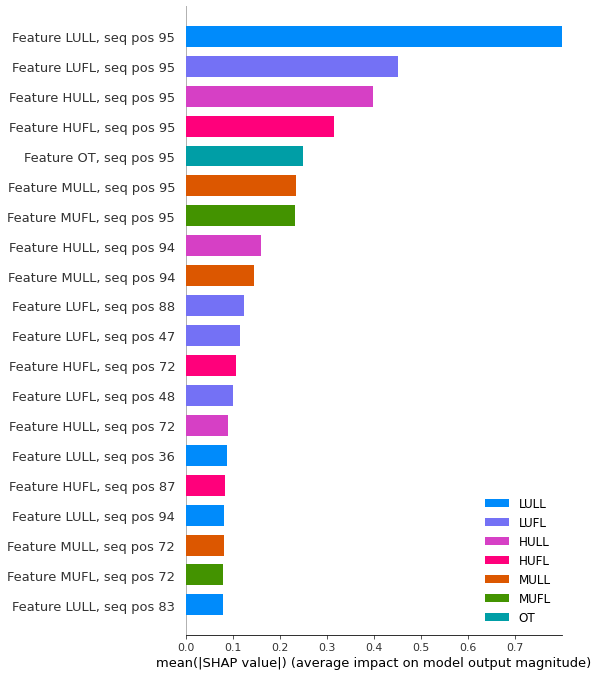

In [15]:
shap.summary_plot(reduced_o_deep_shap_values, reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:])


### Deep SHAP for full time horizon

In [40]:
num_train_samples = 50

if dataset_key == "national_illness":
    num_train_samples = 576

# Get a subset of the train data
batch_x_train_sub = batch_x_train[::round(batch_x_train.shape[0]/num_train_samples+0.5),:,:]

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
exp.device = device
reduced_o_wrapped_model.to(device)

# Flatten X to be fed to the model

reduced_new_input = batch_x.flatten(start_dim=1).to(device)
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1).to(device)

torch.set_grad_enabled(True)

e = shap.DeepExplainer(reduced_o_wrapped_model, reduced_new_input_train)

# Each explained prediction horizon has to be analyzed individually to make it work with SHAP, so we store them in a list
# reduced_deep_shap_values = []

# for pred_hor in range(reduced_o_wrapped_model.pred_len):
#     reduced_o_wrapped_model.set_pred_time_step(pred_hor)
#     print("Analyzing time step ",pred_hor)
#     reduced_deep_shap_values.append(e.shap_values(reduced_new_input))

Analyzing time step  0
Analyzing time step  1
Analyzing time step  2
Analyzing time step  3
Analyzing time step  4
Analyzing time step  5
Analyzing time step  6
Analyzing time step  7
Analyzing time step  8
Analyzing time step  9
Analyzing time step  10
Analyzing time step  11
Analyzing time step  12
Analyzing time step  13
Analyzing time step  14
Analyzing time step  15
Analyzing time step  16
Analyzing time step  17
Analyzing time step  18
Analyzing time step  19
Analyzing time step  20
Analyzing time step  21
Analyzing time step  22
Analyzing time step  23
Analyzing time step  24
Analyzing time step  25
Analyzing time step  26
Analyzing time step  27
Analyzing time step  28
Analyzing time step  29
Analyzing time step  30
Analyzing time step  31
Analyzing time step  32
Analyzing time step  33
Analyzing time step  34
Analyzing time step  35


In [41]:
"Explanations/SHAP/shap_values_{}_in_{}_out_{}_{}_bg_{}.pkl".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples)

'Explanations/SHAP/shap_values_national_illness_in_36_out_36_NLinear_bg_576.pkl'

In [43]:
# with open("Explanations/SHAP/shap_values_{}_in_{}_out_{}_{}_bg_{}.pkl".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples), 'wb') as file:
#     pickle.dump(reduced_deep_shap_values, file)

with open("Explanations/SHAP/shap_values_{}_in_{}_out_{}_{}_bg_{}.pkl".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples), 'rb') as file:
    reduced_deep_shap_values = pickle.load(file)

time step 0


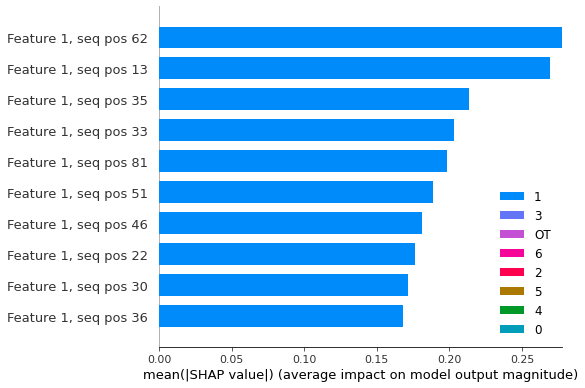

time step 18


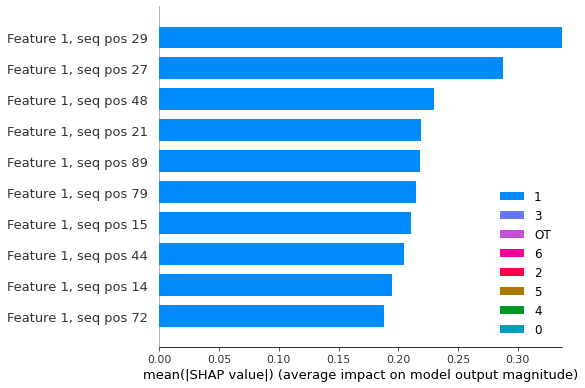

time step 34


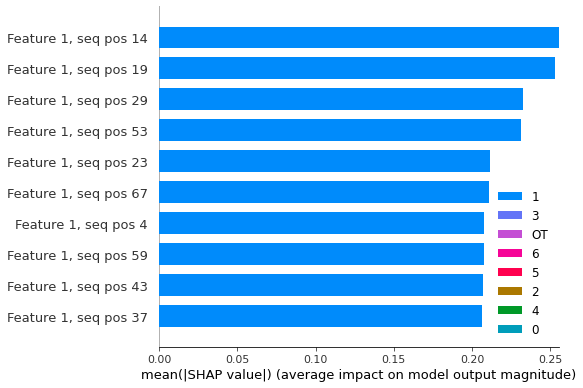

time step 35


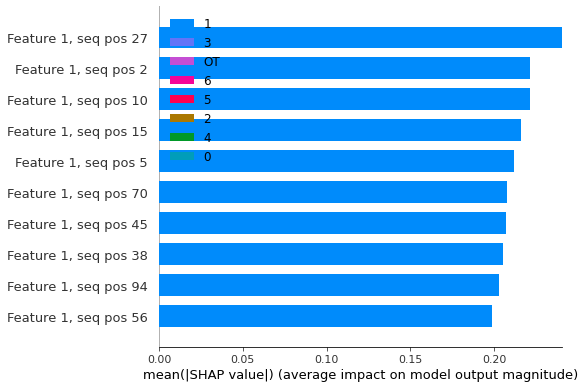

In [15]:
%matplotlib inline

for ind in [0, 18, 34, 35]:
    print("time step {}".format(ind))
    shap.summary_plot(reduced_deep_shap_values[ind], reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:], max_display=10)

### Feature attribution scores evolution over time

We look at the evolution of the attribution scores
considering all time steps from input and output sequences. To
be able to display the overall evolution of the input features’
impact, we look separately into specific output features of the
model, gaining more general information about how the impact
of the features from different time steps of the input varies de-
pending on the prediction horizon.

Input/output mode
accum_signals.shape (36, 36)


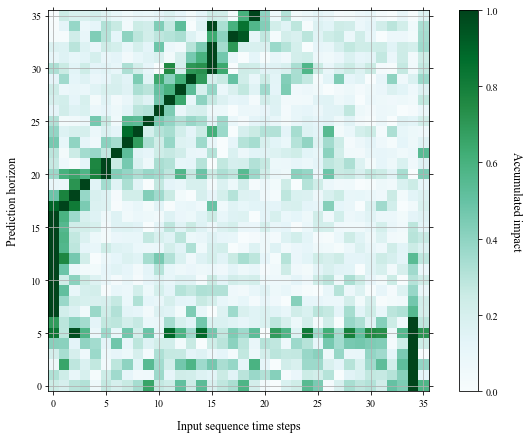

In [44]:
%matplotlib inline 
# %matplotlib qt5

custom_cycler = (cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8]) + 
                 cycler(linestyle=['dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), 
                                   (5, (10, 3)), (0, (5, 10)), (0, (5, 5)), (0, (5, 1))]))
plt.rc('axes', prop_cycle=custom_cycler)

pred_hor = 0
out_feat = 0
mode = 1
save = 1
path = "figures"
fig_name = "\\shap_overview_{}_in_{}_out_{}_{}_bg_{}.pdf".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples)

figsize = (11,7)


ChronoSHAP(reduced_deep_shap_values, exp.args.seq_len, 
                       exp.args.c_out, pred_data.cols[1:], mode, pred_hor, out_feat, grid=1, save=save, path=path+fig_name, figsize=figsize)




Output mode


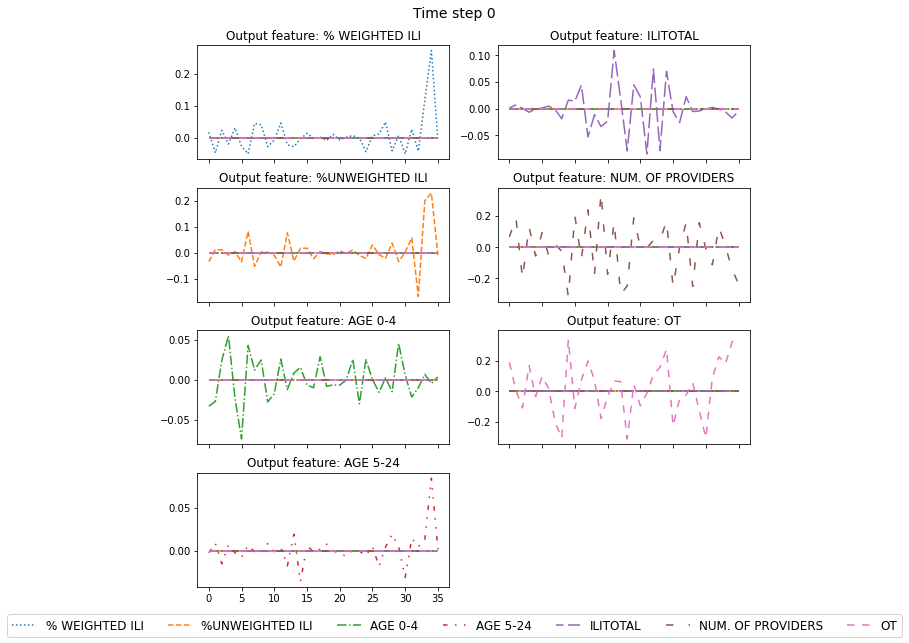

Output mode


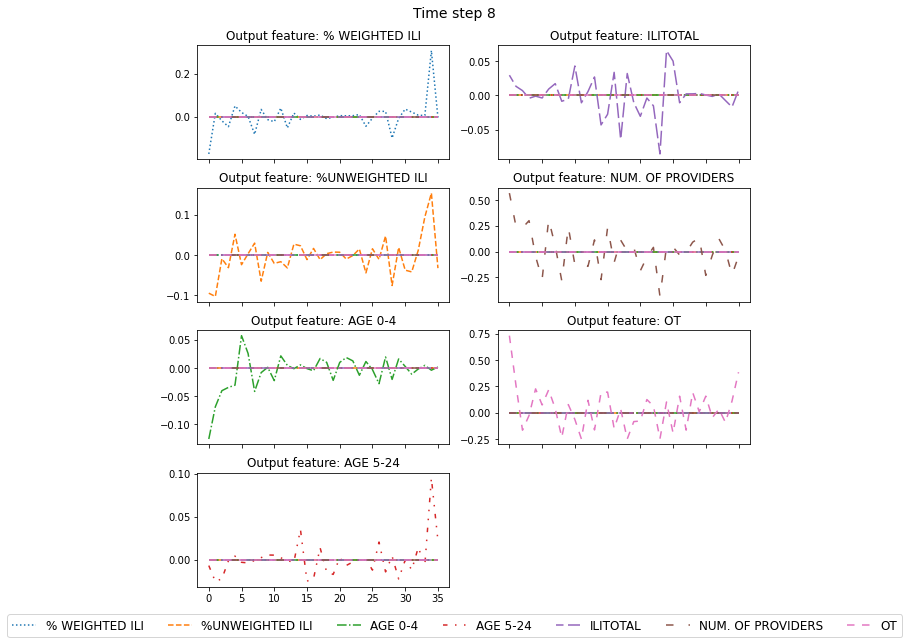

Output mode


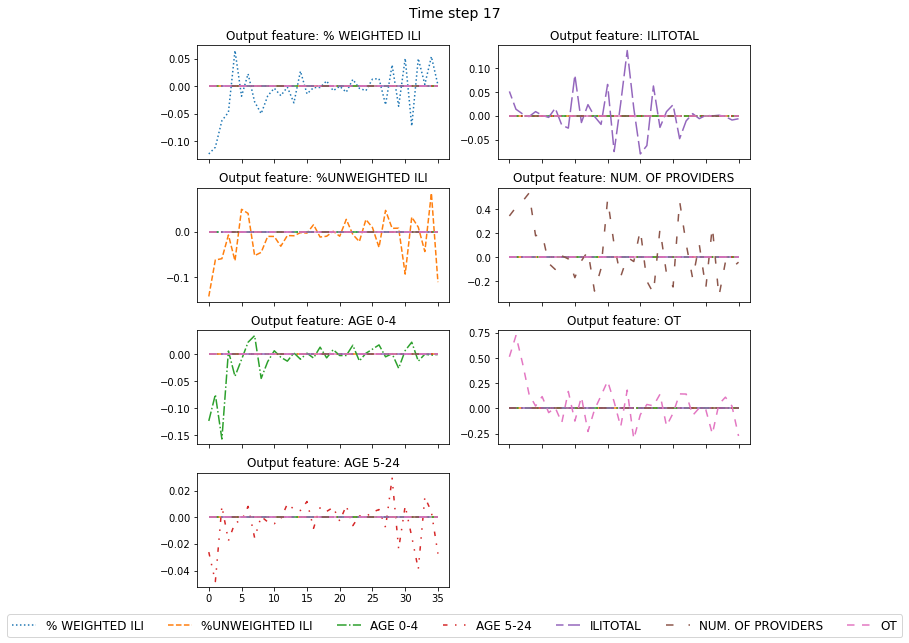

Output mode


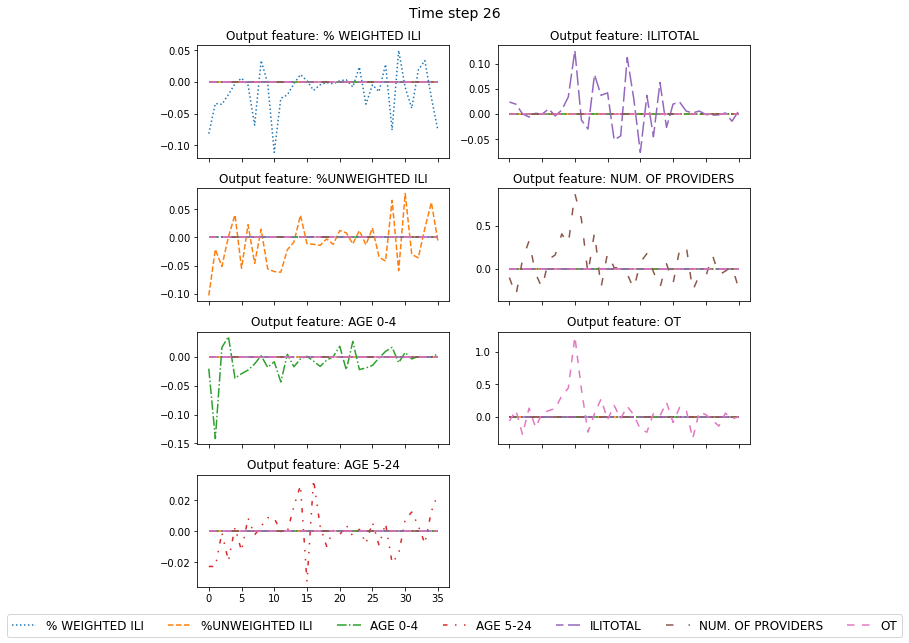

Output mode


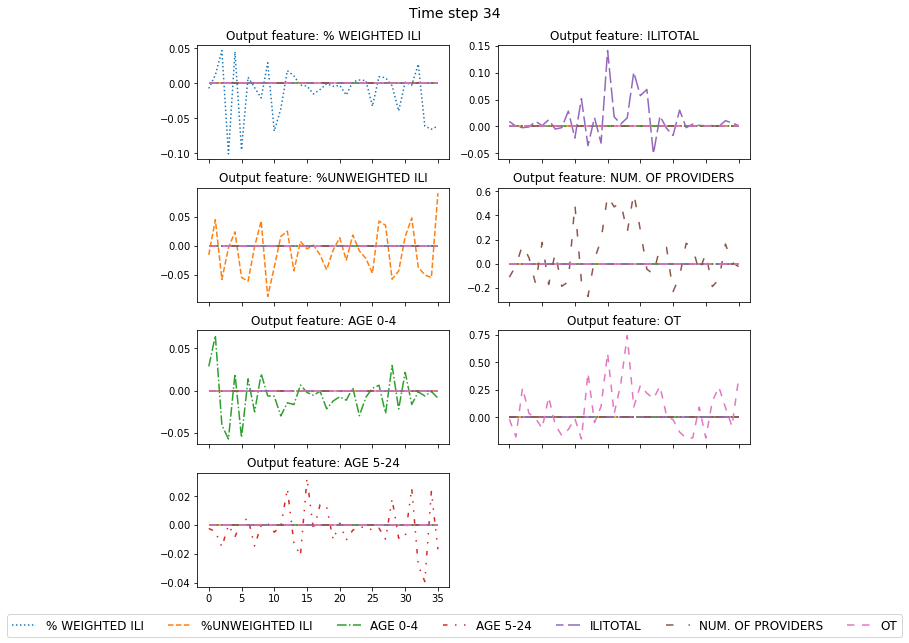

Output mode


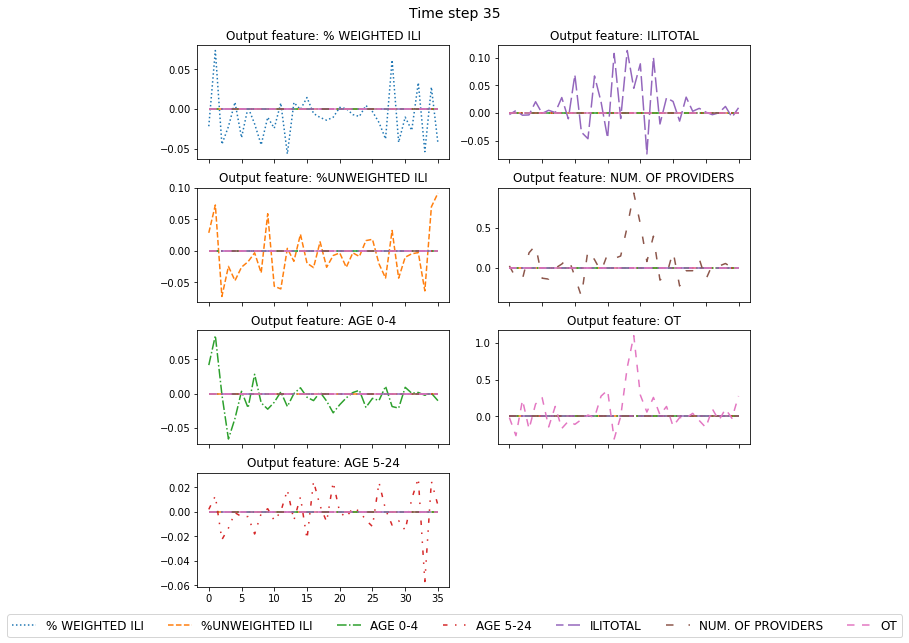

In [17]:
# %matplotlib widget
# matplotlib.use('Qt5Agg')
# %matplotlib inline

custom_cycler = (cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8]) + 
                 cycler(linestyle=['dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), 
                                   (5, (10, 3)), (0, (5, 10)), (0, (5, 5)), (0, (5, 1))]))
plt.rc('axes', prop_cycle=custom_cycler)

out_feat = 0
mode = 0
save = 1
path = "figures"
figsize=(8.5, 9)

for pred_hor in [0, 8, 17, 26, 34, 35]:
# for pred_hor in [0]:
    fig_name = "\\shap_pred_hor_{}_{}_in_{}_out_{}_{}_bg_{}.pdf".format(pred_hor, dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples)
    ChronoSHAP(reduced_deep_shap_values, exp.args.seq_len, 
                       exp.args.c_out, pred_data.cols[1:], mode, pred_hor, out_feat, custom_cycler, grid=0, save=save, path=path+fig_name, figsize=figsize)


# The DLinear model seems to be purely autoregressive
## Check autoregressiveness ;D

### Both original model and wrapped model forecast the same


In [18]:
# Both original model and wrapped model forecast the same

for pred_hor in range(reduced_o_wrapped_model.pred_len):
    reduced_o_wrapped_model.set_pred_time_step(pred_hor)
    print("Predicting time step {}".format(reduced_o_wrapped_model.get_pred_time_step()))
    
    raw_preds_wrapper = reduced_o_wrapped_model(reduced_new_input)
    raw_preds_wrapper = pred_data.inverse_transform(raw_preds_wrapper.cpu().detach().numpy())
    
    raw_preds_model = model(batch_x)[:,pred_hor,:]
    raw_preds_model = pred_data.inverse_transform(raw_preds_model.cpu().detach().numpy())
    
    print((np.abs(raw_preds_wrapper-raw_preds_model)).sum())

Predicting time step 0
0.0
Predicting time step 1
0.0
Predicting time step 2
0.0
Predicting time step 3
0.0
Predicting time step 4
0.0
Predicting time step 5
0.0
Predicting time step 6
0.0
Predicting time step 7
0.0
Predicting time step 8
0.0
Predicting time step 9
0.0
Predicting time step 10
0.0
Predicting time step 11
0.0
Predicting time step 12
0.0
Predicting time step 13
0.0
Predicting time step 14
0.0
Predicting time step 15
0.0
Predicting time step 16
0.0
Predicting time step 17
0.0
Predicting time step 18
0.0
Predicting time step 19
0.0
Predicting time step 20
0.0
Predicting time step 21
0.0
Predicting time step 22
0.0
Predicting time step 23
0.0
Predicting time step 24
0.0
Predicting time step 25
0.0
Predicting time step 26
0.0
Predicting time step 27
0.0
Predicting time step 28
0.0
Predicting time step 29
0.0
Predicting time step 30
0.0
Predicting time step 31
0.0
Predicting time step 32
0.0
Predicting time step 33
0.0
Predicting time step 34
0.0
Predicting time step 35
0.0
Pr

### If we change all inputs features except one, the forecast for that one does not change (indeed is autoregressive, not an error)

In [19]:
aux_batch_x = batch_x.clone().detach()

aux_batch_x[:,:,::2] = 50

(model(batch_x)[:,:,:]-model(aux_batch_x)[:,:,:]).sum(dim=0)

tensor([[-48.6633,   0.0000, -48.7786,   0.0000, -47.7342,   0.0000, -50.5688],
        [-47.2258,   0.0000, -47.3845,   0.0000, -46.7537,   0.0000, -50.5805],
        [-46.5037,   0.0000, -46.7576,   0.0000, -45.3089,   0.0000, -50.4354],
        [-46.1052,   0.0000, -46.5968,   0.0000, -43.8305,   0.0000, -49.8879],
        [-45.2070,   0.0000, -45.8793,   0.0000, -42.3854,   0.0000, -50.0362],
        [-45.2167,   0.0000, -45.5961,   0.0000, -42.1399,   0.0000, -50.0313],
        [-44.2999,   0.0000, -44.8751,   0.0000, -41.4980,   0.0000, -50.0302],
        [-44.0762,   0.0000, -44.6025,   0.0000, -40.9928,   0.0000, -50.1314],
        [-44.2890,   0.0000, -44.4592,   0.0000, -40.8570,   0.0000, -49.7955],
        [-44.2779,   0.0000, -44.6556,   0.0000, -40.3293,   0.0000, -49.6473],
        [-43.8829,   0.0000, -44.2735,   0.0000, -39.6580,   0.0000, -49.6837],
        [-44.3183,   0.0000, -44.9198,   0.0000, -39.6884,   0.0000, -49.6654],
        [-44.7550,   0.0000, -45.2952,  